In [26]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [27]:
np.stack([[1,2],[3,2]], axis=1)

array([[1, 3],
       [2, 2]])

We want to generate some data for the simple harmonic oscillator given by
$$\ddot{x} + \omega^2 x = 0$$
but for simplicity we will set $\omega = 1$.

We will do this by simply giving data as pairs of numbers at time $t$ and $t+dt$, the pair being $x(t)$ and $\dot{x}(t)$, which we will generate knowing the true equation of motion.
 

In [28]:
def generate_sho_data(num_samples=1000, T=20, dt=0.1, omega=1.0):

    X_data = []
    Y_data = []
    
    for _ in range(num_samples):
        # Random initial conditions
        x0 = np.random.uniform(-1.0, 1.0)
        v0 = np.random.uniform(-1.0, 1.0)

        # Analytical solution for SHO with omega=1:
        # x(t) = x0 cos(t) + (v0) sin(t)
        # v(t) = -x0 sin(t) + v0 cos(t)
        # If you want general omega, just use cos(omega t), etc.

        t_vals = np.arange(T) * dt # Create time points, an array from 0 to T*dt with step dt
        x_vals = x0*np.cos(omega*t_vals) + v0*np.sin(omega*t_vals)
        v_vals = -x0*np.sin(omega*t_vals)*omega + v0*np.cos(omega*t_vals)*omega
        # Note that if omega=1, this simplifies, but let's keep it general.

        # Pack into shape (T, 2). Use np.stack but ultimately reshapre using torch.Tensor
        seq = np.stack([x_vals, v_vals], axis=1)  # axis=1 means we stack along the columns
        
        # Next-step targets: shift by 1. We wanto predict the next step given the current step, i.e. go from x(t) to x(t+dt).
        # For the last step, let's just copy the last value or set to zeros
        seq_target = np.zeros_like(seq) # zeros_like creates an array of zeros with the same shape as seq
        seq_target[:-1] = seq[1:]
        seq_target[-1] = seq[-1]  # for convenience

        X_data.append(seq)
        Y_data.append(seq_target)

    X_data = np.array(X_data, dtype=np.float32)  # (num_samples, T, 2)
    Y_data = np.array(Y_data, dtype=np.float32)  # (num_samples, T, 2)

    return X_data, Y_data

Next, we create the transformer which we want to train on this data.

First, we need to encode position into the network. Our data is necessarily _ordered_ from the past into the future, but the transformer doesn't know this (it processes everything at the same time). To get around this, we build a positional encoding, which tags each chuck of data with a position in the sequence. We can inheret PositionalEncoding from pytorch to do this.

Useful torch modules to understand: 
- .unsqueeze(n), which adds a dimension to a tensor at position n. Basically, adding an index to a tensor at position n. Example: $(T^\mu)$.unsqueeze(0) $= T^{\alpha\mu}$

In [29]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=200): # d_model is the number of dimensions in the input, and max_len is the maximum length of the sequence we expect. O've set it to 200 steps by default, but you can change this if you expect longer sequences. 
        super().__init__()
        pe = torch.zeros(max_len, d_model) # initialise a tensor of zeros with shape (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # arange creates a 1D tensor from 0 to max_len, with data type float
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * 
                             (-np.log(10000.0) / d_model)) # Create a list of numbers starting from 0 to d_model with step 2, multiply by -log(10000)/d_model, and exponentiate. This essentially creates a series of decreasing factors which we use to scale the argument of the sin and cos functions.
        pe[:, 0::2] = torch.sin(position * div_term) # :, 0::2 is fancy python for "every other column starting from 0". The general syntax is [start:end:step]
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # We want this to be saved along with the model weights, but not trained, so we register it as a buffer. We also unsqueeze to add a batch dimension of 1.

    def forward(self, x): # forward might be called on a given tensor, x, and this function returns the tensor with positional encoding added
        seq_len = x.size(1) # work out how long the sequence is
        return x + self.pe[:, :seq_len] # return the tensor now with new positional encoding added. We slice the positional encoding to be the same length as the sequence.

Now we have added positional data, we build the transformer, using the pytorch TransformerModel. For this, we need to think about how we want our transformer to behave. We need to create an embedding layer, basically the layer that our inputs will go into and be transformed into the high-dimensional space that is the encoder. Language models will often use nn.Embedding, but we will use nn.Linear, since our data is made up of continuous variables (position and velocity) rather than e.g. tokens.

I've added a _causal mask_, which essentially blocks the transformer from seeing 'future steps', which might have been causing it to make bad predictions. Essentially, the mask is filled with past information and -\infinity anywhere in the future.

In [30]:
def generate_square_subsequent_mask(seq_len: int) -> torch.Tensor:
    """
    Generate a causal _mask_ of shape (seq_len, seq_len).
    Upper-triangular entries (excluding main diagonal) are set to -inf.
    """
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    # Wherever mask == 1, we set to -inf
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask
    
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model) # This is the input embedding layer. It's a simple linear layer that maps the input dimension to the model dimension. In our case, the input dimension is 2: (x(t), x'(t)) and the model dimension is whatever we choose in our hyperparameters (d_model, e.g. 128).
        self.pos_encoder = PositionalEncoding(d_model) # See above

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=num_heads,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout,
                                                   batch_first=True) # The dropout here is basically a regularisation technique. It randomly sets some of the input units to zero with probability p. This supposedly helps to prevent overfitting. The batch_first=True argument means that the input and output tensors are of shape (batch_size, seq_length, input_dim) rather than the default (seq_length, batch_size, input_dim).
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,
                                                         num_layers=num_layers)

        # Now map back to 2D (x, v)
        self.fc_out = nn.Linear(d_model, input_dim)
    
    def forward(self, src):

        # Embedding + positional encoding
        x = self.embedding(src)
        x = self.pos_encoder(x)

        
        # Generate the causal mask for this sequence length
        seq_len = x.size(1)
        mask = generate_square_subsequent_mask(seq_len).to(x.device)

        # Pass mask=mask to enforce auto-regressive attention
        encoded = self.transformer_encoder(x, mask=mask) # Transformer encoder, with the mask applied. This is where the magic happens, and the model learns to predict the next step in the sequence.

        # Map to output dimension. This is the final linear layer that maps the model dimension (e.g. 128) back to the input dimension (2).
        out = self.fc_out(encoded) 
        return out

Now we run the main function, generate some data, (optionally) train the model and then compare with some test data.

Using GPU 0: NVIDIA GeForce RTX 3070
Loaded pre-trained model weights.
[ 0.5         0.5973355   0.68870262  0.77318845  0.84994884  0.91821682
  0.97731028  1.02663878  1.06570945  1.09413189  1.11162214  1.11800542
  1.11321796  1.0973076   1.0704333   1.03286359  0.98497384  0.92724256
  0.86024658  0.7846553   0.70122401  0.61078631  0.51424585  0.4125672
  0.30676632  0.19790034  0.087057   -0.02465619 -0.13612302 -0.24622975
 -0.35387624 -0.45798691 -0.55752153 -0.65148558 -0.7389402  -0.81901157
 -0.89089965 -0.95388616 -1.00734175 -1.05073231 -1.08362431 -1.10568908
 -1.11670618 -1.11656552 -1.10526851 -1.08292802 -1.04976727 -1.00611759
 -0.95241512 -0.88919643 -0.81709318 -0.73682581 -0.64919632 -0.55508027
 -0.45541805 -0.35120544 -0.2434837  -0.13332915 -0.02184242  0.08986255
  0.20066965  0.30947171  0.41518165  0.51674322  0.61314166  0.7034138
  0.78665766  0.86204149  0.9288121   0.98630231  1.03393773  1.07124237
  1.09784352  1.11347538  1.11798176  1.11131764  1.093

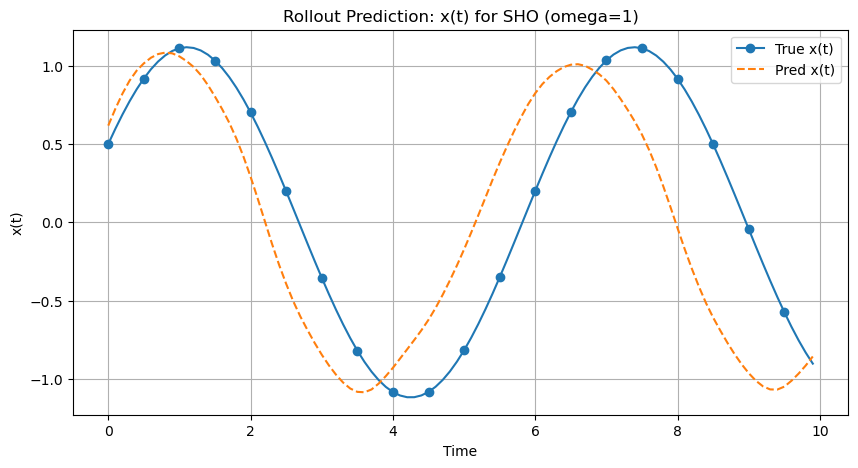

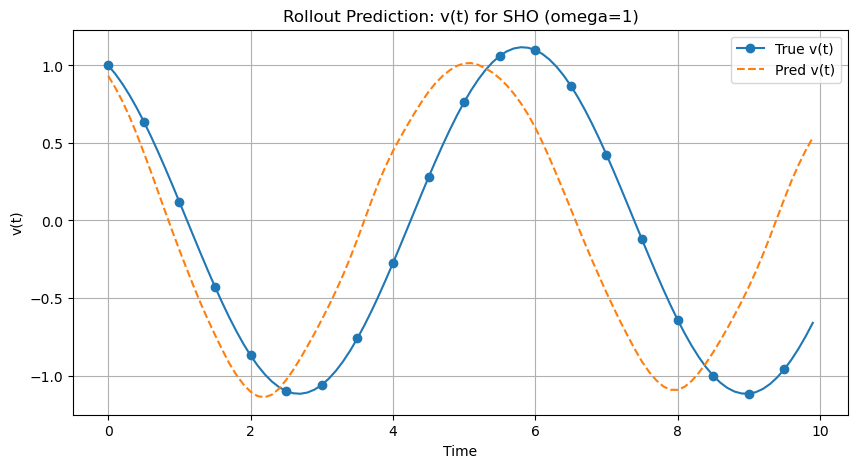

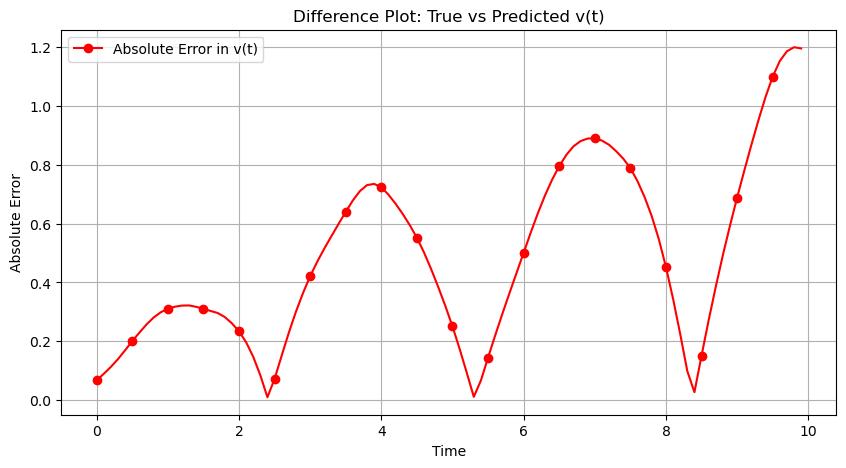

In [36]:
def main():
    # ---------------------------
    # Hyperparameters
    # ---------------------------
    enable_training = False
    # MODEL_PATH = os.path.join(os.path.dirname(__file__), "sho_transformer_model.pth") # Let's keep the model in the same directory as the script for simplicity
    MODEL_PATH = os.path.join(os.path.dirname(os.path.realpath('__file__')), "sho_transformer_model.pth") # Let's keep the model in the same directory as the script for simplicity

    # SHO data parameters
    num_samples = 10000  # how many sequences
    T = 200              # length of each sequence
    dt = 0.1            # time step in the SHO solver

    # Transformer hyperparams
    input_dim = 2       # [x(t), v(t)]
    d_model = 128       # embedding dimension
    num_heads = 2
    num_layers = 4
    dim_feedforward = 64
    dropout = 0.01 # Randomly drop out 10% of the units
    
    # Training hyperparams
    num_epochs = 200
    
    X, Y = generate_sho_data(num_samples, T, dt, omega=1)
    # X, Y have shape (num_samples, T, 2) => (batch, seq_len, channels=[x,v])

    # Convert to torch tensors
    X_tensor = torch.tensor(X)  # (num_samples, T, 2)
    Y_tensor = torch.tensor(Y)  # (num_samples, T, 2)

    # Optional: standardize or not. Sometimes it helps.
    # Here let's do it for demonstration:
    # X_mean = X_tensor.mean(dim=(0,1))   # shape (2,)
    # X_std = X_tensor.std(dim=(0,1))     # shape (2,)
    # X_tensor = (X_tensor - X_mean) / (X_std + 1e-6)
    # Y_tensor = (Y_tensor - X_mean) / (X_std + 1e-6)

    dataset = TensorDataset(X_tensor, Y_tensor)

    # ---------------------------
    # Create model
    # ---------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerModel(input_dim, d_model, num_heads, num_layers, dim_feedforward, dropout)
    model.to(device)
    for i in range(torch.cuda.device_count()):
        print(f"Using GPU {i}: {torch.cuda.get_device_name(i)}")

    # ---------------------------
    # Optionally train
    # ---------------------------
    if enable_training:
        print("Training the model on SHO data...")
        dataset = TensorDataset(X_tensor, Y_tensor)
        if torch.cuda.device_count() > 0:
            dataloader = DataLoader(dataset, batch_size=512, shuffle=True, pin_memory=True) # What's the best batch size for a modern GPU? I've no idea but this works well in testing.
        else:
            dataloader = DataLoader(dataset, batch_size=8, shuffle=True) # Smaller batch size for CPU training

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # lr is the learning rate. This is a hyperparameter that you can tune. It's the step size that the optimizer takes when updating the weights.

        progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
        for epoch in progress_bar:
            model.train()
            total_loss = 0.0

            for batch_X, batch_Y in dataloader:
                batch_X = batch_X.to(device)
                batch_Y = batch_Y.to(device)

                optimizer.zero_grad()
                output = model(batch_X)
                loss = criterion(output, batch_Y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            progress_bar.set_postfix(loss=f"{avg_loss:.6f}")

        # Save trained weights
        torch.save(model.state_dict(), MODEL_PATH)
        print("Training complete. Model saved.")
    else:
        # Load a previously trained model
        model.load_state_dict(torch.load(MODEL_PATH))
        print("Loaded pre-trained model weights.")


    # -------------------------------------------------
    # 4) Testing/Inference by ROLLING OUT
    # -------------------------------------------------
    # Let’s pick a random initial condition for demonstration
    x0_test = 0.5
    v0_test = 1.0
    T_test = 100
    test_t = np.arange(T_test)*dt

    # True solution (for w=1)
    true_x = x0_test*np.cos(test_t) + v0_test*np.sin(test_t)
    true_v = -x0_test*np.sin(test_t) + v0_test*np.cos(test_t)

    # We'll do a "rollout": at each step we feed the previous (x, v).
    # Start from (x0, v0).
    rollout = []
    x_curr = x0_test
    v_curr = v0_test

    model.eval()
    with torch.no_grad():
        for t_idx in range(T_test):
            # Standardize the current input using training mean/std
            inp = np.array([[x_curr, v_curr]], dtype=np.float32)  # shape (1,2)
            #inp = (inp - X_mean.numpy()) / (X_std.numpy() + 1e-6)

            inp_tensor = torch.tensor(inp, dtype=torch.float32).unsqueeze(0).to(device)
            # shape (1, seq_len=1, 2)

            out_tensor = model(inp_tensor)
            # out_tensor shape => (1, 1, 2) => the predicted next [x, v]

            pred = out_tensor.squeeze(0).squeeze(0).cpu().numpy()  # shape (2,)
            # un-standardize
            # pred_unscaled = pred*(X_std.numpy() + 1e-6) + X_mean.numpy()
            pred_unscaled = pred # no standardization
            # record
            rollout.append(pred_unscaled)

            # feed the predicted next step in for next iteration
            x_curr, v_curr = pred_unscaled

    rollout = np.array(rollout)  # shape (T_test, 2)
    pred_x = rollout[:, 0]
    pred_v = rollout[:, 1]
    print(true_x,true_v)
    print(pred_x, pred_v)

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(test_t, true_x, label='True x(t)', marker='o', markevery=5)
    plt.plot(test_t, pred_x, label='Pred x(t)', linestyle='--')
    plt.xlabel("Time")
    plt.ylabel("x(t)")
    plt.legend()
    plt.grid(True)
    plt.title("Rollout Prediction: x(t) for SHO (omega=1)")
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(test_t, true_v, label='True v(t)', marker='o', markevery=5)
    plt.plot(test_t, pred_v, label='Pred v(t)', linestyle='--')
    plt.xlabel("Time")
    plt.ylabel("v(t)")
    plt.legend()
    plt.grid(True)
    plt.title("Rollout Prediction: v(t) for SHO (omega=1)")
    plt.show()

    # Difference plot for v(t)
    diff_v = np.abs(true_v - pred_v)
    plt.figure(figsize=(10,5))
    plt.plot(test_t, diff_v, label='Absolute Error in v(t)', marker='o', markevery=5, color='red')
    plt.xlabel("Time")
    plt.ylabel("Absolute Error")
    plt.legend()
    plt.grid(True)
    plt.title("Difference Plot: True vs Predicted v(t)")
    plt.show()
    
if __name__ == "__main__":
    main()
    